# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Importing all the modules
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import json
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # Use GPU if it's available

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir  = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir  = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean, std)])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(), 
                                       transforms.Normalize(mean, std)])
test_transforms  = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(), 
                                       transforms.Normalize(mean, std)])

# TODO: Load the datasets with ImageFolder
trainset = datasets.ImageFolder(train_dir, transform=train_transforms)
validset = datasets.ImageFolder(valid_dir, transform=valid_transforms)
testset  = datasets.ImageFolder(test_dir,  transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=32, shuffle=False)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=32, shuffle=False)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [5]:
model = models.vgg19(pretrained=True)
for param in model.features.parameters():    # freeze convolution weights
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:44<00:00, 12817697.04it/s]


In [6]:
# Setup the model
input_size    = 25088
hidden_units  = 4096
output_size   = 102
learning_rate = 0.002

model.classifier = nn.Sequential(nn.Linear(input_size, hidden_units),
                                 nn.ReLU(),
                                 nn.Linear(hidden_units, output_size),
                                 nn.LogSoftmax(dim=1))  
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
model.to(device);

In [7]:
def valid_model(model, loader, criterion, optimizer):
    """ Test the accuracy of the model.
        Parameters:
        ===========
        inputs:  object - model, loader, criterion, optimizer 
        outputs: float - loss, accuracy
    """
    valid_loss, accuracy = 0, 0
    model.eval()           # Turn model into "inference mode"

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
            valid_loss += batch_loss.item()

            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    model.train()      # Turn model back into learning mode
    return valid_loss, accuracy

In [8]:
# Key parameters
epochs = 3
steps  = 0
running_loss = 0       # Loss for a group of steps defined by print every
print_every  = 100
model.train()          # Turn the training mode
train_lost_history = []
for epoch in range(epochs):
    print(f"Starting epoch:{epoch+1} with {len(trainloader)} steps")
    for inputs, labels in trainloader:
        steps += 1
        
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_lost_history.append(loss.item())
        
        # Check testing accuracy from time to time
        if steps % print_every == 0:
            valid_loss, accuracy = valid_model(model, validloader, criterion, optimizer)
            print(f"Epoch {epoch+1}/{epochs}, Step {steps}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Valid loss: {valid_loss/len(validloader):.3f}.. "
                  f"Valid accuracy: {100*accuracy/len(validloader):.2f}%")
            model.train()      # Turn model back into learning mode
            running_loss = 0
            
        #print(f"Epoch {epoch+1}/{epochs}.. steps {steps}..")
print("*** DONE ***")        

Starting epoch:1 with 205 steps
Epoch 1/3, Step 100.. Train loss: 4.949.. Valid loss: 1.772.. Valid accuracy: 51.48%
Epoch 1/3, Step 200.. Train loss: 1.908.. Valid loss: 1.344.. Valid accuracy: 64.62%
Starting epoch:2 with 205 steps
Epoch 2/3, Step 300.. Train loss: 1.521.. Valid loss: 1.044.. Valid accuracy: 72.80%
Epoch 2/3, Step 400.. Train loss: 1.327.. Valid loss: 0.898.. Valid accuracy: 75.20%
Starting epoch:3 with 205 steps
Epoch 3/3, Step 500.. Train loss: 1.239.. Valid loss: 0.855.. Valid accuracy: 76.34%
Epoch 3/3, Step 600.. Train loss: 1.206.. Valid loss: 0.914.. Valid accuracy: 76.40%


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [9]:
# TODO: Do validation on the test set
print(f"Testing the network with {len(testloader)} tests")
test_loss, accuracy = valid_model(model, testloader, criterion, optimizer)
print(f"Test loss: {test_loss/len(testloader):.3f}.. "
      f"Test accuracy: {100*accuracy/len(testloader):.2f}%")

Testing the network with 26 tests
Test loss: 1.114.. Test accuracy: 72.91%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [10]:
# TODO: Save the checkpoint 
model.class_to_idx = trainset.class_to_idx
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

state = {'arch': 'vgg19',
         'hidden_units': hidden_units,
         'epochs': epochs,
         'l_rate': learning_rate,
         'class_to_idx': model.class_to_idx,
         'state_dict': model.state_dict(),
         'optimizer':  optimizer.state_dict()}

#checkpoint_name = 'check-' + model_name + '.pth'
checkpoint_name = 'checkpoint.pth'
torch.save(state, checkpoint_name)

Our model: 

 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17):

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [11]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    """ Creates a model based on the saved checkpoint dictionary. It then loads the model state dictionary."""
    # Fix found on stackoverflow 
    # https://stackoverflow.com/questions/55759311/runtimeerror-cuda-runtime-error-35-cuda-driver-version-is-insufficient-for
    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'

    checkpoint = torch.load(filepath, map_location=map_location)
    arch          = checkpoint['arch']
    hidden_units  = checkpoint['hidden_units']
    learning_rate = checkpoint['l_rate']
    epochs        = checkpoint['epochs']
    print(f"Loading the model: {arch}")
    
    if arch == 'vgg19':
        model = models.vgg19(pretrained=True)
    elif arch == 'vgg16':
        model = models.vgg16(pretrained=True)
    else:
        print(f"*** ERROR *** model architecture is {arch} => should be vgg19 or vgg16")
        sys.exit(1)
              
    for param in model.parameters():            # freeze parameters
        param.requires_grad = False
        
    model.class_to_idx = checkpoint['class_to_idx']
      
    # Create the clasifier again          
    input_size  = 25088
    output_size = 102
    model.classifier = nn.Sequential(nn.Linear(input_size, hidden_units),
                                     nn.ReLU(),
                                     nn.Linear(hidden_units, output_size),
                                     nn.LogSoftmax(dim=1))            
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [12]:
checkpoint_name = 'checkpoint.pth'
model = load_checkpoint(checkpoint_name)
#print(model)
model.to(device);

Loading the model: vgg19


## Checking that loading worked

In [13]:
print(f"Testing the network with {len(testloader)} tests")
test_loss, accuracy = valid_model(model, testloader, criterion, optimizer)
print(f"Test loss: {test_loss/len(testloader):.3f}.. "
      f"Test accuracy: {100*accuracy/len(testloader):.2f}%")

Testing the network with 26 tests
Test loss: 1.114.. Test accuracy: 72.91%


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [14]:
def process_image(img):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model.
        Paremeters:
        ============
        img:     single PIL image object
        returns: single image tensor [3, width, height]
    ''' 
      
    # These are the ImageNet normalizing mean and std
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225])  
    
    # Create a transformation that converts PIL to Tensor and normalizes the image
    image_transform = transforms.Compose([transforms.Resize(256),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean, std)])
    pil_to_tensor = image_transform(img)

    return pil_to_tensor

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [15]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [16]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
        Parameters:
        ===========
        image_path: string - location of the image
        model:      object - model
        topk:       integer - number of class we want to review
        returns:
        =========
        top_p:      list of float - probabilities
        top_class:  list of integers - index of the classes
    '''
    # TODO: Implement the code to predict the class from an image file
    model.to(device);
    model.eval()
    img = Image.open(image_path)
    img_tensor = process_image(img)
    img_tensor.unsqueeze_(0)           # Ensures the 1st argument of tensor is the batchsize
    img_tensor = img_tensor.to(device)
    logps = model.forward(img_tensor)
    ps = torch.exp(logps)
    top_p, top_class = ps.topk(5, dim=1)
    return top_p, top_class

In [17]:
def get_image_paths(flower_number):
    """ Helper to find flower images in the workspace.
        Parameters:
        ===========
        flower_number: string
        outputs:       list of strings
    """
    #print(os.getcwd())
    #print(os.listdir())
    
    list_images = os.listdir('flowers/test/'+flower_number)
    base = 'flowers/test/'
    image_paths = [base+flower_number+'/'+x for x in list_images]
    return image_paths

In [21]:
flower_number = '42'
image_paths = get_image_paths(flower_number)
image_path = image_paths[0]
mapping = model.class_to_idx
probs, classes = predict(image_path, model)
probs = probs.cpu()
classes = classes.cpu()
print(probs, classes)
#imshow(img_tensor)

tensor([[ 0.7852,  0.0681,  0.0502,  0.0371,  0.0102]]) tensor([[ 39,  12,   9,  97,  92]])


In [22]:
image_path

'flowers/test/42/image_05696.jpg'

In [23]:
probs.detach().numpy().squeeze()

array([ 0.78524631,  0.06805468,  0.0502392 ,  0.0371009 ,  0.01015333], dtype=float32)

In [28]:
def class_to_name(classes, mapping, cat_to_name):
    """ Convert the classes to flower names.
        Parameters:
        ===========
        classes:     list of str - index of the top 5 classes
        mapping:     dict - maps index to flower numbers (the key)
        cat_to_name: dict - maps the flower numbers to names
        returns:     list str - names of flowers
        """
    
    class_values = classes.cpu().numpy().squeeze()                    # convert to numpy and remove extra []
    keys = []
    for value in class_values:                                  # Find the matching key for all the classes
        #print(value)
        tmp = [k for k,v in mapping.items() if v == value][0]   # Need the [0] to remove the list
        keys.append(tmp)
        
    names = [cat_to_name[key] for key in keys]                  # Convert into names
    return names

In [29]:
class_to_name(classes, mapping, cat_to_name)

['daffodil', 'peruvian lily', 'yellow iris', 'bougainvillea', 'canna lily']

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [32]:
# TODO: Display an image along with the top 5 classes
def plot_predictions(image_path, model, cat_to_name):
    mapping = model.class_to_idx
    probs, classes = predict(image_path, model)                # Make prediction
    flowers = class_to_name(classes, mapping, cat_to_name)


    plt.figure(figsize = (6, 10))
    ax = plt.subplot(2, 1, 1)
    
    title_ = flowers[0]
    
    # Plot flower
    img = process_image(Image.open(image_path))
    print(type(img))
    imshow(img, ax, title = title_);

    # Plot bar chart
    plt.subplot(2, 1, 2)
    probs =  probs.cpu().detach().numpy().squeeze()               # Need to convert tensor to array and remove extra []
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);

<class 'torch.Tensor'>


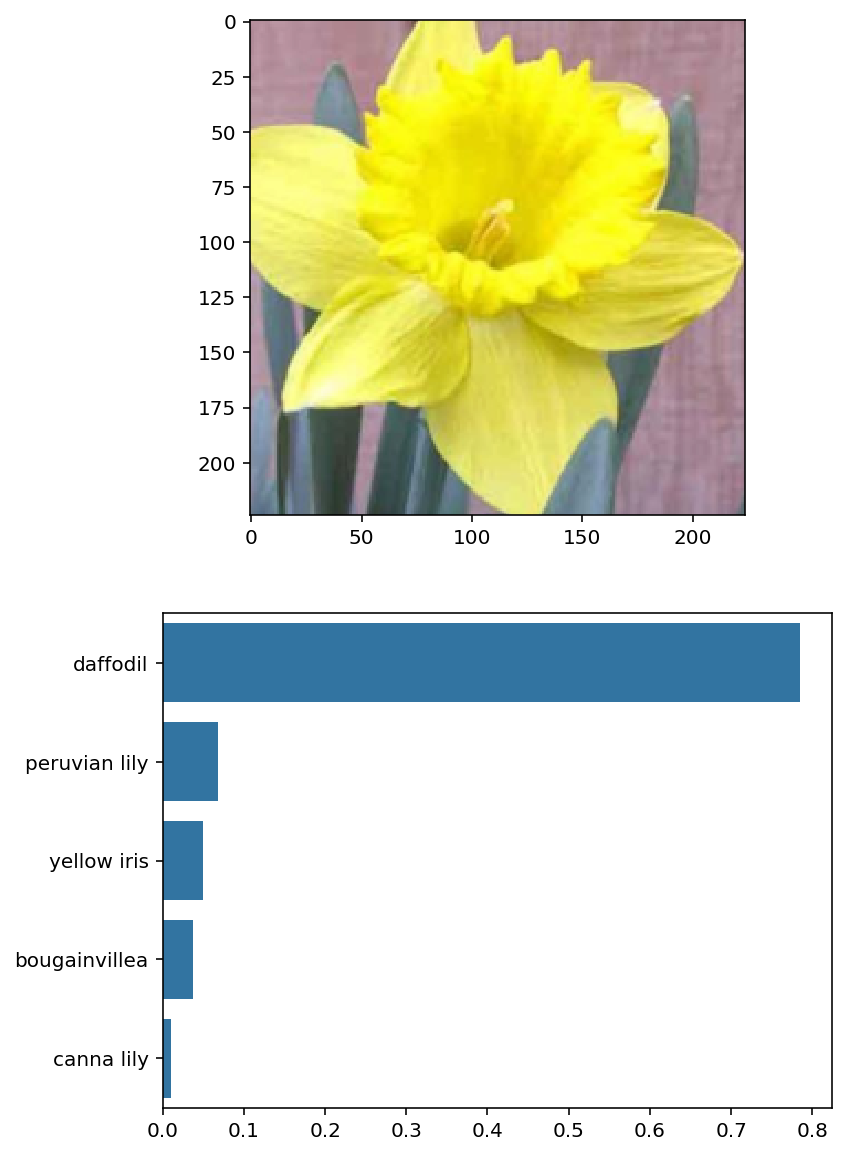

In [33]:
plot_predictions(image_path, model, cat_to_name)

# NOT USED ANYMORE

### Testing on flowers

In [12]:
flower_number = '42'
image_paths= get_image_paths(flower_number)
print(f"Found {len(image_paths)} images")
image_path = image_paths[0]
image_path

Found 4 images


'flowers/test/42/image_05696.jpg'

daffodil


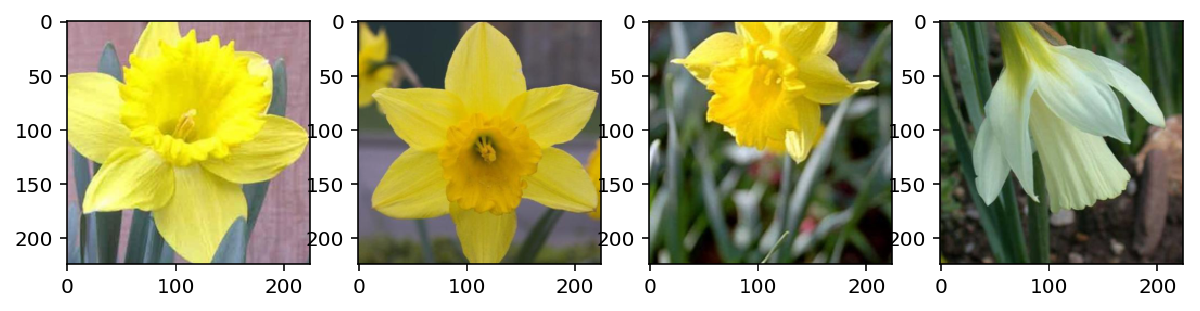

In [13]:
# See the first 4 flowers
title = cat_to_name[flower_number]
print(title)
img = [Image.open(image_paths[x]) for x in range(4)]
img_tensor = [process_image(img[x]) for x in range(4)]


fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(img_tensor[ii], ax=ax)

In [16]:
probs, classes = probs.to(device), classes.to(device)        
class_value = classes.numpy().squeeze()[0]                   # convert to numpy then take the 1st item of the 1st vector

key = [k for k,v in mapping.items() if v == class_value][0]
value = cat_to_name[key]
print(f"key: {key} flower: {value}")

key: 42 flower: daffodil


In [ ]:
def crop_image(img, size):
    """ Crop a PIL image at the center sizeXsize. The PIL modul method .crop() needs to know the margins.
        Parameters:
        ============
        img:     PIL image object
        size:    int crop size
        returns: PIL image object
    """
    left_margin = (img.width-224) / 2    # Find the extra horizontal pixels and divide by two
    bottom_margin = (img.height-224) / 2 # Find the extra vertical pixels and divide by two
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin, top_margin))
    return img

In [ ]:
img = Image.open(image_path)
img_tensor = process_image(img)
print(img_tensor.shape, img_tensor.dtype)
img_tensor.unsqueeze_(0)
print(img_tensor.shape)